In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from magic_wand import *

from scipy.ndimage import median_filter
from pylab import rcParams
rcParams['figure.figsize'] = 20, 20 #width x height in inches
# Load the 3D model
tumor_3d_model = tf.keras.models.load_model(r"C:\Users\kaczm\programming\3DRDNN\models\new_yt_3D_lesion\03-0.4084.hdf5")


# let's start with normal image and make some predictions

import SimpleITK as sitk
import glob
from tqdm import tqdm


def preprocessing_3d(t1) -> np.ndarray:
    min = -200
    max = 250
    t1 = np.where(t1 < min, min, t1)
    t1 = np.where(t1 > max, max, t1)
    t1 -= min
    return t1 / (max-min)


def label_seperator_liver(img):
    img = np.where(img == 2, 1, img)
    return img


def label_seperator_lesion(img):
    img = np.where(img == 1, 0, img)
    img = np.where(img == 2, 1, img)
    return img


def reading_data(path: str) -> np.ndarray:
    sitk_t1 = sitk.ReadImage(path)
    t1 = sitk.GetArrayFromImage(sitk_t1)
    t1 = t1.reshape(t1.shape[0], t1.shape[1], t1.shape[2], 1)

    t1 = tf.dtypes.cast(t1, tf.float32)

    return t1

def label_seperator_liver(img):
        img = np.where(img == 2, 1, img)
        return img

def z_transform(img_volume, img_seg, param_z=256):
        return_img_volume = np.zeros(
            (param_z, img_volume.shape[1], img_volume.shape[2], img_volume.shape[3])
        )
        return_img_seg = np.zeros(
            (param_z, img_seg.shape[1], img_seg.shape[2], img_seg.shape[3])
        )
        for i in range(img_seg.shape[1]):
            return_img_volume[:, i, :, 0:1] = tf.image.resize(
                img_volume[:, i, :, 0:1], [param_z, 512])
            return_img_seg[:, i, :, 0:1] = tf.image.resize(
                img_seg[:, i, :, 0:1],
                [param_z, 512],
                method="nearest",
            )
        return return_img_volume, return_img_seg


path = "data\\LITS_Challenge\\train\\"
files_volume = glob.glob(path + "\\volume*.nii")
files_segmenation = glob.glob(path + "\\segmentation*.nii")

avg_liver = 0.668377
std_liver = 0.081813
standarized_avg = 0.19115860874010746

In [2]:

gt = reading_data(files_segmenation[0])
print(gt.shape)

(501, 512, 512, 1)


In [3]:
from skimage import measure


In [4]:
np.where(gt == 1)


type(gt)


gt_numpy = gt.numpy()

In [5]:
np.where(gt==2)

(array([327, 327, 327, ..., 472, 472, 472], dtype=int64),
 array([226, 226, 226, ..., 346, 346, 347], dtype=int64),
 array([108, 109, 110, ..., 194, 195, 194], dtype=int64),
 array([0, 0, 0, ..., 0, 0, 0], dtype=int64))

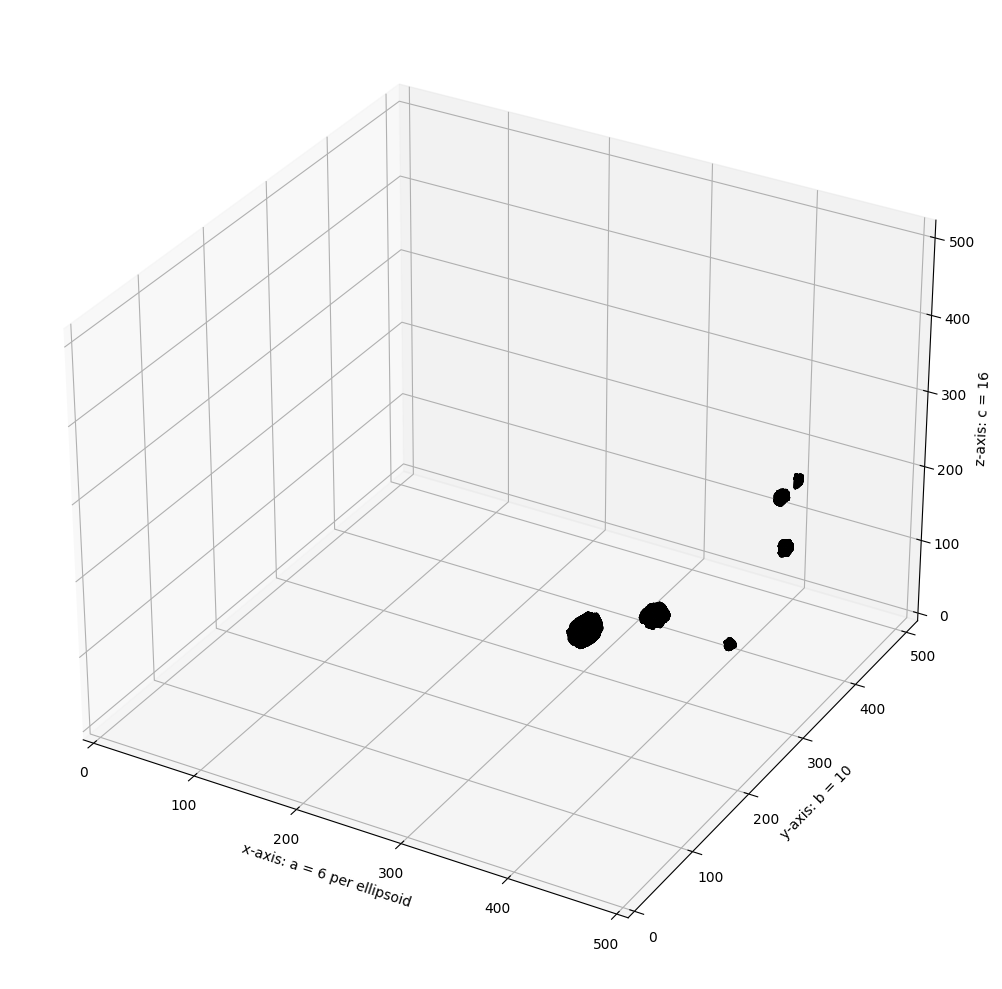

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

from skimage import measure
from skimage.draw import ellipsoid


# Generate a level set about zero of two identical ellipsoids in 3D
ellip_base = ellipsoid(6, 10, 16, levelset=True)
ellip_double = np.concatenate((ellip_base[:-1, ...],
                               ellip_base[2:, ...]), axis=0)

# Use marching cubes to obtain the surface mesh of these ellipsoids
verts, faces, normals, values = measure.marching_cubes(gt_numpy[:,:,:,0]==2, 0)

# Display resulting triangular mesh using Matplotlib. This can also be done
# with mayavi (see skimage.measure.marching_cubes docstring).
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Fancy indexing: `verts[faces]` to generate a collection of triangles
mesh = Poly3DCollection(verts[faces])
mesh.set_edgecolor('k')
ax.add_collection3d(mesh)

ax.set_xlabel("x-axis: a = 6 per ellipsoid")
ax.set_ylabel("y-axis: b = 10")
ax.set_zlabel("z-axis: c = 16")

ax.set_xlim(0, 500)  # a = 6 (times two for 2nd ellipsoid)
ax.set_ylim(0, 512)  # b = 10
ax.set_zlim(0, 512)  # c = 16

plt.tight_layout()
plt.show()

In [7]:
import skimage



In [10]:
new_image = np.zeros((15,15,15))

new_image[3:6,5,5] = 1
new_image[3:9,9,9]  = 1


new_image[3:15,11,13] = 1
print(np.sum(new_image))

21.0


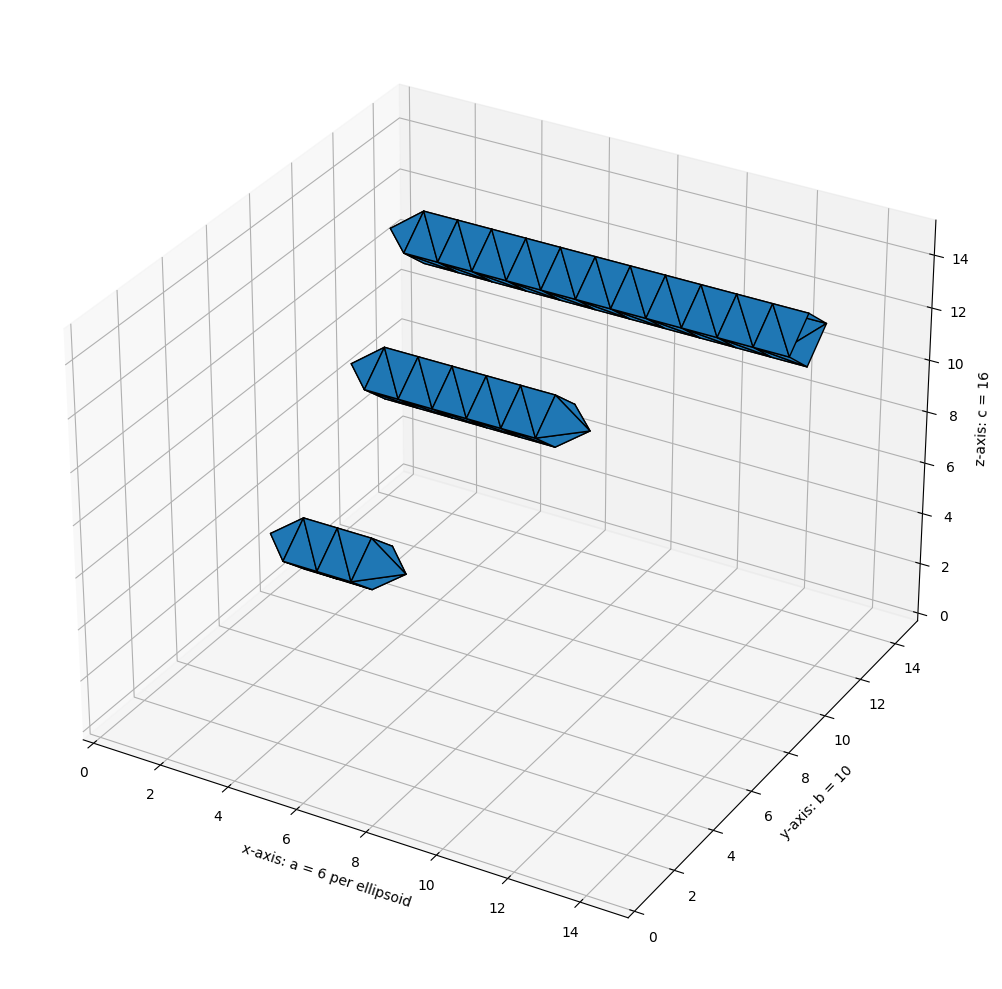

In [11]:
verts, faces, normals, values = measure.marching_cubes(new_image, 0)

# Display resulting triangular mesh using Matplotlib. This can also be done
# with mayavi (see skimage.measure.marching_cubes docstring).
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Fancy indexing: `verts[faces]` to generate a collection of triangles
mesh = Poly3DCollection(verts[faces])
mesh.set_edgecolor('k')
ax.add_collection3d(mesh)

ax.set_xlabel("x-axis: a = 6 per ellipsoid")
ax.set_ylabel("y-axis: b = 10")
ax.set_zlabel("z-axis: c = 16")

ax.set_xlim(0, 15)  # a = 6 (times two for 2nd ellipsoid)
ax.set_ylim(0, 15)  # b = 10
ax.set_zlim(0, 15)  # c = 16

plt.tight_layout()
plt.show()

In [12]:
res = skimage.measure.moments(new_image, order=3)[0,0,0]
print(res)

21.0


In [13]:
from scipy.ndimage import label

# Assuming your binary mask is stored in the variable 'mask'
labeled_mask, num_labels = label(gt_numpy[:,:,:,0]==2)


print(np.unique(labeled_mask))
print(num_labels)
# Iterate through each label and extract the corresponding region
regions = []
for label_id in range(1, num_labels + 1):
    region = (labeled_mask == label_id)
    regions.append(region)

# 'regions' will contain a list of binary masks, each representing a separate region


[0 1 2 3 4 5 6]
6


In [14]:
len(regions)

6

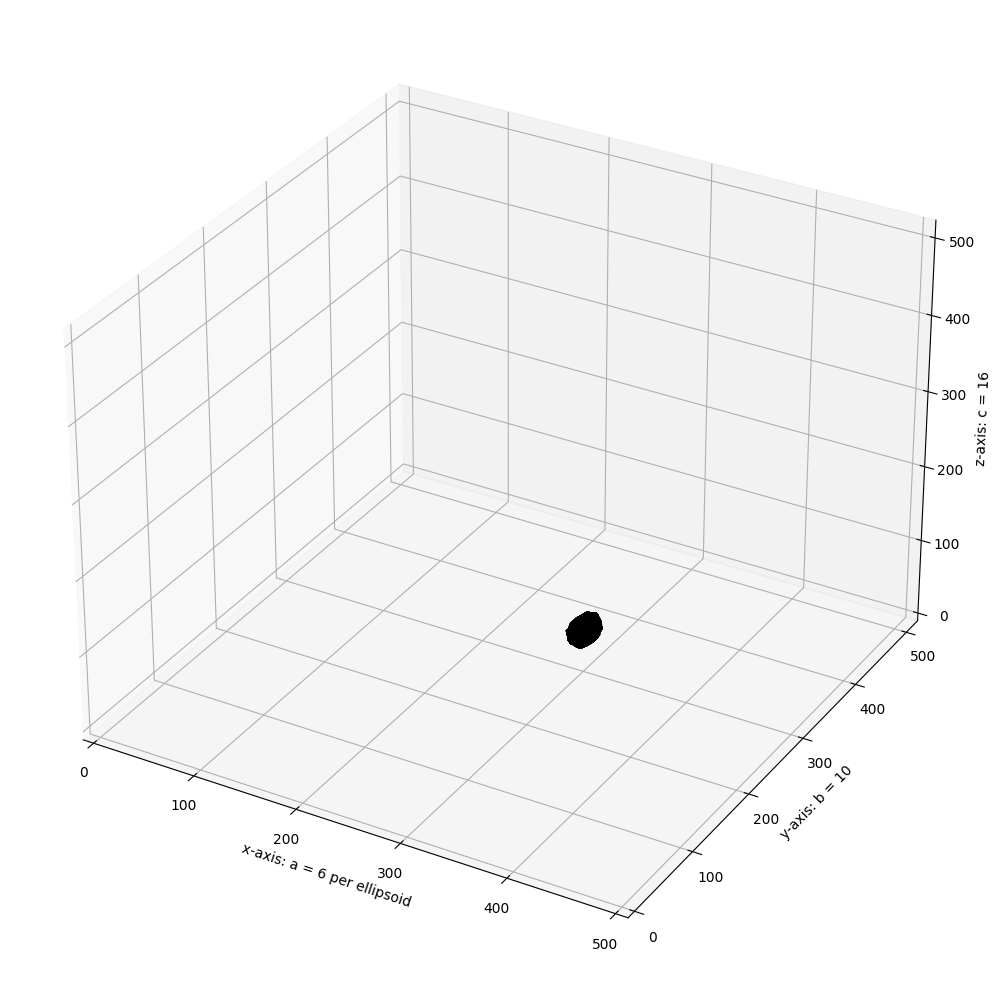

In [15]:
new_new_image = np.zeros((gt_numpy.shape))
new_new_image[regions[0]] = 1

verts, faces, normals, values = measure.marching_cubes(new_new_image[:,:,:,0], 0)

# Display resulting triangular mesh using Matplotlib. This can also be done
# with mayavi (see skimage.measure.marching_cubes docstring).
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Fancy indexing: `verts[faces]` to generate a collection of triangles
mesh = Poly3DCollection(verts[faces])
mesh.set_edgecolor('k')
ax.add_collection3d(mesh)

ax.set_xlabel("x-axis: a = 6 per ellipsoid")
ax.set_ylabel("y-axis: b = 10")
ax.set_zlabel("z-axis: c = 16")

ax.set_xlim(0, gt_numpy.shape[0])  # a = 6 (times two for 2nd ellipsoid)
ax.set_ylim(0, gt_numpy.shape[1])  # b = 10
ax.set_zlim(0, gt_numpy.shape[2])  # c = 16

plt.tight_layout()
plt.show()

In [24]:
M = skimage.measure.moments(new_new_image[:,:,:,0], order=3)

print(M[0,0,0])

print(np.sum(new_new_image[:,:,:,0]))


centroid_x = M[1,0,0] / M[0,0,0]
centroid_y = M[0,1,0] / M[0,0,0]
centroid_z = M[0,0,1] / M[0,0,0]
print(centroid_x, centroid_y, centroid_z)


14570.0
14570.0
340.9330130404942 227.6354152367879 114.02457103637612
21.364584763212093


In [44]:
pdist([[0,0,0]  , [1,1,1], [2,2,2]])

array([1.73205081, 3.46410162, 1.73205081])

In [86]:
import numpy as np
from skimage.measure import label, regionprops

# Assuming your binary image is stored in the variable 'image'
labeled_image = label(gt_numpy[:,:,:,0]==2)


print(np.unique(labeled_image))
# Find the regions in the labeled image
regions = regionprops(labeled_image)

# Initialize variables to store the longest axis length and its orientation
longest_axis_length = 0
longest_axis_orientation = 0

# for 3D
regions = regionprops(labeled_image)

regions_list = np.zeros(len(regions))

volume_list  = np.zeros(len(regions))
for i,region in enumerate(regions):
    longest_axis_length = 0
    longest_axis_orientation = 0

    y0, x0,z0 = region.centroid
    # Get the major axis length and orientation of the region
    major_axis_length = region.major_axis_length
    #orientation = region.orientation

    # Check if the major axis length is longer than the current longest axis length
    
    longest_axis_length = major_axis_length
    regions_list[i] = longest_axis_length

        #longest_axis_orientation = orientation
    volume_list[i] = np.sum(labeled_image==i)


print("Longest Axis Length:", regions_list)
print("Longest Axis Orientation:", volume_list)

longest_axis_length = 0
longest_axis_orientation = 0


regions_list_2d = np.max(np.unique(labeled_image))
volume_list  = np.zeros(len(regions))

for i in range(np.max(np.unique(labeled_image))):
    probbing_image = np.where(labeled_image==i+1, 1,0)
    longest_axis_length = 0
    longest_axis_orientation = 0
    for j in range(len(labeled_image)):
        one_slice = probbing_image[j,:,:]

        if np.sum(one_slice) == 0:
            continue
        else:
            region_2d = regionprops(one_slice)

            print(region_2d)
            y0, x0 = region_2d.centroid
            # Get the major axis length and orientation of the region_2d
            major_axis_length = region_2d.major_axis_length
            orientation = region_2d.orientation
            
            # Check if the major axis length is longer than the current longest axis length
            if major_axis_length > longest_axis_length:
                longest_axis_length = major_axis_length
                longest_axis_orientation = orientation
    regions_list_2d[i] = longest_axis_length
    volume_list[i] += np.sum(one_slice)



print("Longest Axis Length:", regions_list_2d)
print("Longest Axis Orientation:", volume_list)


[0 1 2 3 4 5 6]
Longest Axis Length: [45.53254537 27.39292443 12.82141885 16.87744905 17.20237297 18.06951684]
Longest Axis Orientation: [1.31309834e+08 1.45700000e+04 6.27100000e+03 5.54000000e+02
 1.20600000e+03 1.38700000e+03]
[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0

AttributeError: 'list' object has no attribute 'centroid'

In [81]:
print(region)